<a href="https://colab.research.google.com/github/melihkurtaran/DNA_hackathon/blob/main/MainCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing necessary packages

In [52]:
import os
from pathlib import Path

import cv2
import gif2numpy
import matplotlib.pyplot as plt
import numpy as np
import yaml
from yaml.loader import SafeLoader

## Defining necessary constants

In [44]:
DATASET_PATH = Path("./dataset/dataset_v1/aemet/10min")
YAML_PATH = Path("./dataset/radars.yaml")

PALMA_DATASET_PATH = DATASET_PATH / "pm"
VALENCIA_DATASET_PATH = DATASET_PATH / "va"
BARCELONA_DATASET_PATH = DATASET_PATH / "ba"

## Digitizing the dataset

In [48]:
with open(YAML_PATH, 'r') as f:
    data = yaml.load(f, Loader=SafeLoader)

In [51]:
palma_location_data = data["data"]["PM"]
valencia_location_data = data["data"]["VA"]
barcelona_location_data = data["data"]["BA"]
barcelona_location_data

{'rdr_code': 'ba',
 'latitude': 41.4082,
 'longitude': 1.88499,
 'radius': 240,
 'name': 'Barcelona'}

In [59]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:
        center = (int(w/2), int(h/2))
    
    if radius is None:
        radius = min(center[0], center[1], w-center[0], h-center[1])
        
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    
    mask = dist_from_center <= radius
    return mask

In [102]:
class LocationData():
    def __init__(self, location_data, gif_path):
        np_frames, _, image_specs = gif2numpy.convert(gif_path)
        self.image = np_frames[0]
        _, dim, _ = self.image.shape
        self.image = self.image[:dim, :, ::-1]
        self.height, self.width, _ = self.image.shape
        
        mask = self._create_circular_mask()
        self.image[~mask] = 0
        
        latitude = float(location_data["latitude"])
        longitude = float(location_data["longitude"])
        
        # Degrees in 1 pixel
        self.lat_diff = 1 / 110.574
        self.long_diff = 1 / (111.320 * np.cos(latitude))
        
    def _create_circular_mask(self):
        center = (int(self.width/2), int(self.height/2))
        radius = min(center[0], center[1], self.width-center[0], self.height-center[1])

        Y, X = np.ogrid[:self.height, :self.width]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

        mask = dist_from_center <= radius
        return mask

dataset/dataset_v1/aemet/10min/ba/20220101/aemet_ba_202201010000.gif


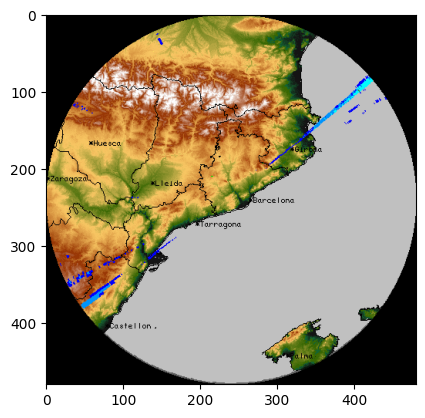

In [108]:
for day_folder_name in sorted(os.listdir(BARCELONA_DATASET_PATH)):
    day_folder_path = BARCELONA_DATASET_PATH / day_folder_name
    
    for image_name in sorted(os.listdir(day_folder_path)):
        image_path = day_folder_path / image_name
        
        image_data = LocationData(barcelona_location_data, image_path)
        
        plt.imshow(image_data.image)
        plt.show()
        break
        
    break

In [111]:
palma_image_path = "dataset/dataset_v1/aemet/10min/pm/20220101/aemet_pm_202201010000.gif"
valencia_image_path = "dataset/dataset_v1/aemet/10min/va/20220101/aemet_va_202201010000.gif"
barcelona_image_path = "dataset/dataset_v1/aemet/10min/ba/20220101/aemet_ba_202201010000.gif"

palma_image_data = LocationData(palma_location_data, palma_image_path)
valencia_image_data = LocationData(valencia_location_data, valencia_image_path)
barcelona_image_data = LocationData(barcelona_location_data, barcelona_image_path)

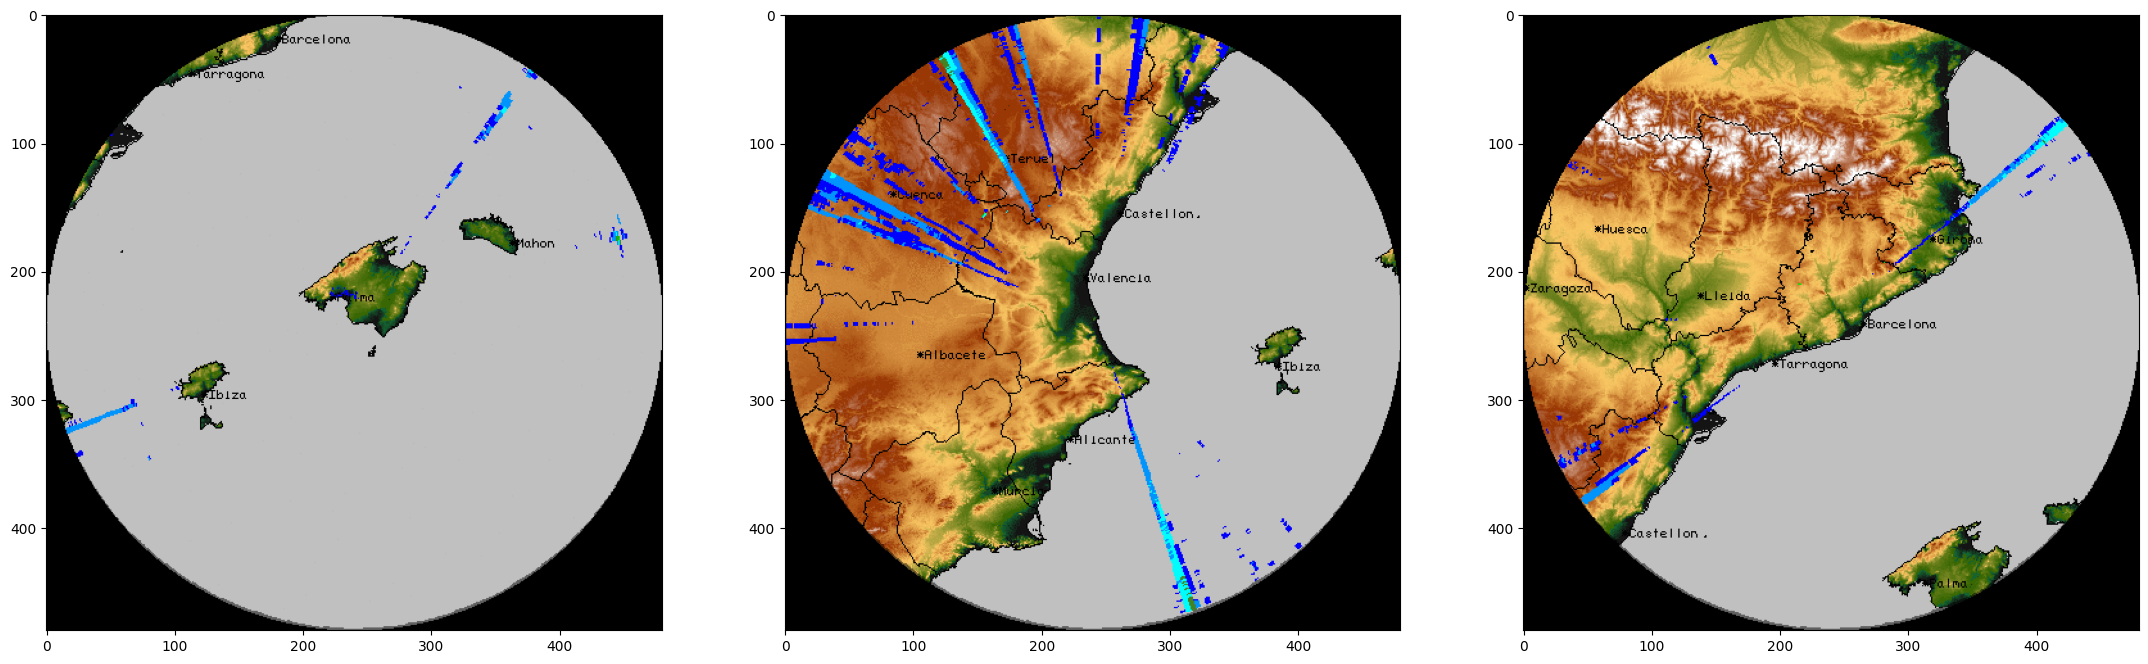

In [116]:
fig, ax = plt.subplots(1, 3, figsize=(27, 9))
ax[0].imshow(palma_image_data.image)
ax[1].imshow(valencia_image_data.image)
ax[2].imshow(barcelona_image_data.image)
plt.show()

In [118]:
palma_image_data.long_diff, valencia_image_data.long_diff, barcelona_image_data.long_diff

(-0.08193207483814463, 0.09609509633959179, -0.010652965851564633)

/home/faranio/Desktop/EDISS/DNA_hackathon/venv/lib/python3.9/site-packages/shapely/ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))
/home/faranio/Desktop/EDISS/DNA_hackathon/venv/lib/python3.9/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))


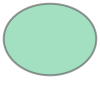

In [184]:
# from functools import partial
# from shapely.geometry import Point
# from shapely.ops import transform

# import pyproj

# lon, lat = palma_location_data["longitude"], palma_location_data["latitude"]
# radius = palma_location_data["radius"] * 1000

# local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(lat, lon)
# wgs84_to_aegd = partial(
#     pyproj.transform,
#     pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
#     pyproj.Proj(local_azimuthal_projection)
# )
# aeqd_to_wgs84 = partial(
#     pyproj.transform,
#     pyproj.Proj(local_azimuthal_projection),
#     pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs")
# )

# center = Point(float(lon), float(lat))
# point_transformed = transform(wgs84_to_aegd, center)
# buffer = point_transformed.buffer(radius)
# circle_poly = transform(aeqd_to_wgs84, buffer)
# circle_poly

(480, 480, 3)

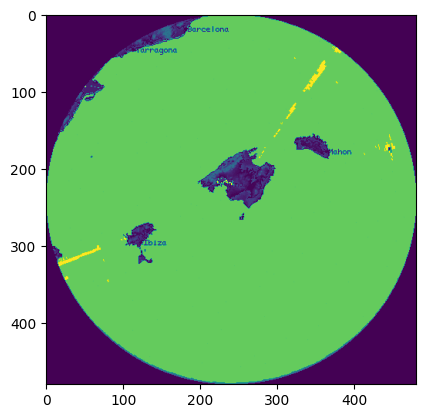

In [243]:
plt.imshow(palma_image_data.image[:, :, 2])
palma_image_data.image.shape

In [277]:
import rasterio

from rasterio.transform import Affine

center_longitude, center_latitude = barcelona_location_data["longitude"], barcelona_location_data["latitude"]
radius = barcelona_location_data["radius"] * 1000

height, width, _ = barcelona_image_data.image.shape

x = np.arange(0, width, 1)
y = np.arange(0, height, 1)

latitudes = center_latitude - (height/2 - y) * 1 / 110.574
longitudes = center_longitude - (width/2 - x) * 1 / (111.320 * np.cos(latitudes * np.pi / 180))

xres = (longitudes[-1] - longitudes[0]) / len(longitudes)
yres = (latitudes[-1] - latitudes[0]) / len(latitudes)

transform = Affine.translation(longitudes[0] - xres/2, latitudes[0] - yres/2) * Affine.scale(xres, yres)

with rasterio.open(
    "./barcelona.tif",
    mode='w',
    driver="GTiff",
    height=height,
    width=width,
    count=3,
    dtype=barcelona_image_data.image.dtype,
    crs="+proj=latlong",
    transform=transform
) as f:
    f.write(barcelona_image_data.image[:, :, 0], 1)
    f.write(barcelona_image_data.image[:, :, 1], 2)
    f.write(barcelona_image_data.image[:, :, 2], 3)

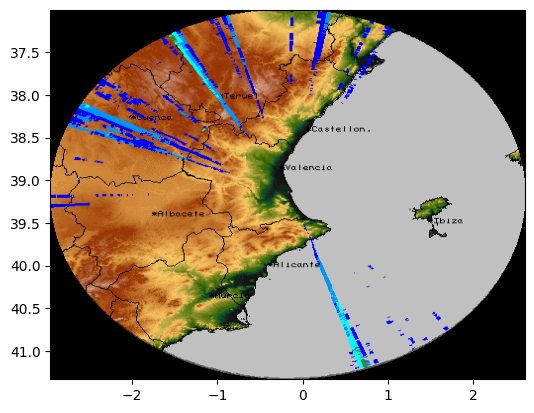

<AxesSubplot: >

In [278]:
from rasterio.plot import show

raster = rasterio.open("./valencia.tif")

show(raster)

In [280]:
from rasterio.merge import merge

image1 = rasterio.open("./palma.tif")
image2 = rasterio.open("./barcelona.tif")
image3 = rasterio.open("./valencia.tif")

mosaic = [image1, image2, image3]

mosaic, output = merge(mosaic)

show(mosaic, cmap="terrain")

WindowError: Bounds and transform are inconsistent